In [1]:
import pandas as pd 


In [2]:
# UK PMI Workforce Sustainability Analysis
# Problem: Estimate high-cost conditions and identify at-risk members for targeted interventions

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# ===========================
# 1. DATA LOADING & PREPARATION
# ===========================

# Load the datasets
membership_df = pd.read_csv('uk_pmi_membership_120k.csv', index_col=0)
claims_df = pd.read_csv('uk_pmi_claims_200k.csv', index_col=0)

print("="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"\nMembership Records: {len(membership_df):,}")
print(f"Claims Records: {len(claims_df):,}")
print(f"\nMembership Columns: {list(membership_df.columns)}")
print(f"\nClaims Columns: {list(claims_df.columns)}")


DATA OVERVIEW

Membership Records: 120,000
Claims Records: 200,000

Membership Columns: ['Client Identifier', 'Scheme Category/ Section Name', 'Scheme Category/ Section Name Identifier', 'Unique Member Reference', 'Unique ID', 'Status of Member', 'Status of Registration', 'Year of Birth', 'Gender', 'Short Post Code of Member', 'Contract Start Date', 'Contract End Date', 'Original Date of Joining', 'Scheme Policy Joining Date', 'Registration Status', 'Lapse Date']

Claims Columns: ['Client Identifier', 'Scheme Category/ Section Name', 'Scheme Category/ Section Name Identifier', 'Status of Member', 'Claimant Unique ID', 'Claimant Year of Birth', 'Claimant Gender', 'Short Post Code', 'Unique Member Reference', 'Contract Start Date', 'Contract End Date', 'Claim ID', 'Incurred Date', 'Paid Date', 'Condition Code', 'Impairment Code', 'Condition Category', 'Treatment Type', 'Claim Type', 'Ancillary Service Type', 'Treatment Location', 'Provider Type', 'Admission Date', 'Discharge Date', 'Calc

In [3]:

# ===========================
# 2. DATA INTEGRATION & FEATURE ENGINEERING
# ===========================

# Merge datasets on Claimant Unique ID
merged_df = claims_df.merge(
    membership_df,
    left_on='Claimant Unique ID',
    right_on='Unique ID',
    how='left',
    suffixes=('_claim', '_member')
)

print(f"\nMerged Records: {len(merged_df):,}")

# Calculate member age
merged_df['Age'] = 2025 - merged_df['Claimant Year of Birth']
merged_df['Age_Group'] = pd.cut(merged_df['Age'], 
                                  bins=[0, 18, 30, 40, 50, 60, 120], 
                                  labels=['0-18', '19-30', '31-40', '41-50', '51-60', '60+'])

# Convert dates
merged_df['Incurred Date'] = pd.to_datetime(merged_df['Incurred Date'])
merged_df['Paid Date'] = pd.to_datetime(merged_df['Paid Date'])


# Calculate claim processing time
merged_df['Processing_Days'] = (merged_df['Paid Date'] - merged_df['Incurred Date']).dt.days



Merged Records: 200,000


In [4]:
# ===========================
# 3. CONDITION CLASSIFICATION & RISK STRATIFICATION
# ===========================

# Define chronic/high-cost conditions
CHRONIC_CONDITIONS = {
    'Cardiovascular': ['401', '402', '410', '411', '412', '413', '414', '415', '416', '417', '427', '428', '429'],
    'Oncology': ['153', '154', '162', '174', '185', '189', '191', '193', '194'],
    'Musculoskeletal_Chronic': ['715', '716', '720', '721', '722', '724', '725', '726', '728'],
    'Mental_Health_Chronic': ['401', 'V70','296', '300', '301', '311'],
    'Respiratory_Chronic': ['414','493', '494', '496'],
    'Endocrine_Chronic': ['780','250', '251', '252', '253'],
    'Gastroenterology_Chronic': ['530', '726', '556','555', '556', '571', '572']
}

def classify_condition_severity(row):
    condition_code = str(row['Condition Code'])
    claim_amount = row['Claim Amount']
    
    # Check if chronic condition
    is_chronic = False
    condition_category = 'Other'
    
    for category, codes in CHRONIC_CONDITIONS.items():
        if any(condition_code.startswith(code) for code in codes):
            is_chronic = True
            condition_category = category
            break
    
    # Classify severity
    if claim_amount > 30000:
        severity = 'Critical_High_Cost'
    elif claim_amount > 10000:
        severity = 'High_Cost'
    elif claim_amount > 5000:
        severity = 'Moderate_Cost'
    elif is_chronic:
        severity = 'Chronic_Condition'
    else:
        severity = 'Low_Risk'
    
    return pd.Series([is_chronic, condition_category, severity])

merged_df[['Is_Chronic', 'Condition_Category', 'Severity']] = merged_df.apply(
    classify_condition_severity, axis=1
)

In [5]:
merged_df.sample(5)

,Client Identifier_claim,Scheme Category/ Section Name_claim,Scheme Category/ Section Name Identifier_claim,Status of Member_claim,Claimant Unique ID,Claimant Year of Birth,Claimant Gender,Short Post Code,Unique Member Reference_claim,Contract Start Date_claim,...,Original Date of Joining,Scheme Policy Joining Date,Registration Status,Lapse Date,Age,Age_Group,Processing_Days,Is_Chronic,Condition_Category,Severity
49883,CLI0011,Standard Plan,SCH0005,Partner,MEM00003847-02,1979,Female,L3,MEM00003847,2021-02-24,...,2018-11-18,2020-06-25,Active,NaN,46,41-50,36,True,Endocrine_Chronic,Chronic_Condition
160190,CLI0011,Advanced Cover,SCH0011,Partner,MEM00041687-02,1998,Female,SW2,MEM00041687,2024-09-01,...,2021-11-03,2023-10-17,Active,NaN,27,19-30,36,False,Other,Low_Risk
156669,CLI0008,Advanced Cover,SCH0011,Member,MEM00051804-01,1958,Male,OX2,MEM00051804,2020-08-19,...,2019-04-23,2020-08-04,Active,NaN,67,60+,20,True,Cardiovascular,Chronic_Condition
148414,CLI0008,Enhanced Plan,SCH0006,Dependent,MEM00047026-03,2005,Male,EC2,MEM00047026,2021-11-24,...,2021-11-08,2021-10-16,Active,NaN,20,19-30,64,True,Respiratory_Chronic,Chronic_Condition
75871,CLI0008,Complete Care,SCH0010,Partner,MEM00019634-02,1979,Female,SE1,MEM00019634,2024-06-18,...,2023-01-27,2023-08-11,Active,NaN,46,41-50,39,True,Musculoskeletal_Chronic,Chronic_Condition


In [6]:
# ===========================
# 4. MEMBER-LEVEL AGGREGATION
# ===========================

print("\n" + "="*80)
print("MEMBER-LEVEL RISK ANALYSIS")
print("="*80)

# Aggregate claims at member level
member_summary = merged_df.groupby('Claimant Unique ID').agg({
    'Claim Amount': ['sum', 'mean', 'count', 'max'],
    'Amount Paid': ['sum'],
    'Is_Chronic': 'max',
    'Age': 'first',
    'Gender': 'first',
    'Condition Category': lambda x: ', '.join(x.unique()),
    'Treatment Type': lambda x: ', '.join(x.unique()[:3])
}).reset_index()

# Flatten column names
member_summary.columns = ['Claimant Unique ID', 'Total_Claim_Cost', 'Avg_Claim_Cost', 
                          'Claim_Count', 'Max_Single_Claim', 'Total_Paid',
                          'Has_Chronic_Condition', 'Age', 'Gender', 
                          'Condition_Categories', 'Treatment_Types']

# Calculate risk score (0-100)
member_summary['Risk_Score'] = (
    (member_summary['Total_Claim_Cost'] / member_summary['Total_Claim_Cost'].max() * 40) +
    (member_summary['Claim_Count'] / member_summary['Claim_Count'].max() * 20) +
    (member_summary['Has_Chronic_Condition'] * 30) +
    (member_summary['Age'] / 100 * 10)
)

# Risk stratification
member_summary['Risk_Category'] = pd.cut(
    member_summary['Risk_Score'],
    bins=[0, 30, 50, 70, 100],
    labels=['Low', 'Medium', 'High', 'Critical']
)

print(f"\nTotal Unique Members: {len(member_summary):,}")
print(f"\nMembers with Chronic Conditions: {member_summary['Has_Chronic_Condition'].sum():,} ({member_summary['Has_Chronic_Condition'].sum()/len(member_summary)*100:.1f}%)")
print(f"\nTotal Claim Costs: £{member_summary['Total_Claim_Cost'].sum():,.2f}")
print(f"Average Cost per Member: £{member_summary['Total_Claim_Cost'].mean():,.2f}")


MEMBER-LEVEL RISK ANALYSIS

Total Unique Members: 42,000

Members with Chronic Conditions: 38,080 (90.7%)

Total Claim Costs: £1,137,522,743.21
Average Cost per Member: £27,083.87


In [7]:
# ===========================
# 5. KEY INSIGHTS & VISUALIZATIONS
# ===========================

print("\n" + "="*80)
print("KEY FINDINGS: HIGH-COST & CHRONIC CONDITIONS")
print("="*80)

# A. Condition prevalence and costs
condition_analysis = merged_df.groupby('Condition Category').agg({
    'Claim Amount': ['sum', 'mean', 'count'],
    'Claimant Unique ID': 'nunique',
    'Is_Chronic': 'mean'
}).reset_index()

condition_analysis.columns = ['Condition', 'Total_Cost', 'Avg_Cost', 'Claim_Count', 
                               'Member_Count', 'Chronic_Rate']
condition_analysis = condition_analysis.sort_values('Total_Cost', ascending=False)

print("\nTOP CONDITIONS BY TOTAL COST:")
print(condition_analysis.head(10).to_string(index=False))

# B. High-cost member identification
high_cost_members = member_summary[member_summary['Total_Claim_Cost'] > 20000].sort_values(
    'Total_Claim_Cost', ascending=False
)

print(f"\n HIGH-COST MEMBERS (>£20,000):")
print(f"Count: {len(high_cost_members):,} ({len(high_cost_members)/len(member_summary)*100:.1f}%)")
print(f"Total Cost: £{high_cost_members['Total_Claim_Cost'].sum():,.2f}")
print(f"% of Total Spend: {high_cost_members['Total_Claim_Cost'].sum()/member_summary['Total_Claim_Cost'].sum()*100:.1f}%")

# C. Risk stratification summary
risk_distribution = member_summary.groupby('Risk_Category').agg({
    'Claimant Unique ID': 'count',
    'Total_Claim_Cost': 'sum',
    'Has_Chronic_Condition': 'sum'
}).reset_index()

print("\n RISK STRATIFICATION:")
print(risk_distribution.to_string(index=False))


KEY FINDINGS: HIGH-COST & CHRONIC CONDITIONS

TOP CONDITIONS BY TOTAL COST:
       Condition   Total_Cost     Avg_Cost  Claim_Count  Member_Count  Chronic_Rate
        Oncology 498716237.15 16331.005212        30538         12570       1.00000
  Cardiovascular 173883660.90  6659.912708        26109         10608       1.00000
 Musculoskeletal 122845253.00  2836.024864        43316         16619       1.00000
 General Surgery  79844243.02  5925.361263        13475          6883       0.00000
Gastroenterology  69357670.15  3746.430624        18513          8844       1.00000
      Preventive  44420516.83  2030.466555        21877         10500       0.50112
   Mental Health  39134994.17  2282.323099        17147          8711       1.00000
       Endocrine  35188283.50  3718.119558         9464          5027       1.00000
   Ophthalmology  28377480.98  3972.211783         7144          4145       0.00000
         General  22885159.96  3740.627650         6118          3687       1.00000

In [8]:
# ===========================
# 6. PREDICTIVE MODELING - HIGH RISK IDENTIFICATION
# ===========================

print("\n" + "="*80)
print("PREDICTIVE RISK MODEL")
print("="*80)

# Prepare features for modeling
modeling_df = member_summary.copy()
modeling_df['High_Risk'] = (modeling_df['Risk_Category'].isin(['High', 'Critical'])).astype(int)

# Feature engineering
le_gender = LabelEncoder()
modeling_df['Gender_Encoded'] = le_gender.fit_transform(modeling_df['Gender'].fillna('Unknown'))

features = ['Age', 'Claim_Count', 'Avg_Claim_Cost', 'Max_Single_Claim', 
            'Has_Chronic_Condition', 'Gender_Encoded']
X = modeling_df[features].fillna(0)
y = modeling_df['High_Risk']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Evaluate
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_score:.2%}")
print(f"Testing Accuracy: {test_score:.2%}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n Feature Importance:")
print(feature_importance.to_string(index=False))

# Predict probabilities for all members
modeling_df['Risk_Probability'] = rf_model.predict_proba(X)[:, 1]


PREDICTIVE RISK MODEL

Model Performance:
Training Accuracy: 100.00%
Testing Accuracy: 99.99%

 Feature Importance:
              Feature  Importance
          Claim_Count    0.761491
     Max_Single_Claim    0.101586
       Avg_Claim_Cost    0.092861
       Gender_Encoded    0.022769
                  Age    0.021269
Has_Chronic_Condition    0.000025


In [9]:
# ===========================
# 7. TARGETED INTERVENTION RECOMMENDATIONS
# ===========================

print("\n" + "="*80)
print("TARGETED INTERVENTION STRATEGY")
print("="*80)

# Identify members needing intervention
intervention_candidates = modeling_df[
    (modeling_df['Risk_Probability'] > 0.6) | 
    (modeling_df['Has_Chronic_Condition'] == 1) |
    (modeling_df['Total_Claim_Cost'] > 15000)
].sort_values('Risk_Probability', ascending=False)

print(f"\n Members Requiring Intervention: {len(intervention_candidates):,} ({len(intervention_candidates)/len(modeling_df)*100:.1f}%)")
print(f"Potential Cost Impact: £{intervention_candidates['Total_Claim_Cost'].sum():,.2f}")

# Intervention categories
def recommend_intervention(row):
    if row['Has_Chronic_Condition'] and row['Total_Claim_Cost'] > 20000:
        return 'Intensive_Case_Management'
    elif row['Has_Chronic_Condition']:
        return 'Chronic_Disease_Management'
    elif row['Risk_Probability'] > 0.7:
        return 'Preventive_Outreach'
    elif row['Claim_Count'] > 5:
        return 'Utilization_Management'
    else:
        return 'Wellness_Program'

intervention_candidates['Intervention_Type'] = intervention_candidates.apply(
    recommend_intervention, axis=1
)

intervention_summary = intervention_candidates.groupby('Intervention_Type').agg({
    'Claimant Unique ID': 'count',
    'Total_Claim_Cost': 'sum'
}).reset_index()

print("\n RECOMMENDED INTERVENTIONS:")
print(intervention_summary.to_string(index=False))


TARGETED INTERVENTION STRATEGY

 Members Requiring Intervention: 38,304 (91.2%)
Potential Cost Impact: £1,132,867,058.52

 RECOMMENDED INTERVENTIONS:
         Intervention_Type  Claimant Unique ID  Total_Claim_Cost
Chronic_Disease_Management               30437      9.839927e+07
 Intensive_Case_Management                7643      1.021715e+09
          Wellness_Program                 224      1.275285e+07


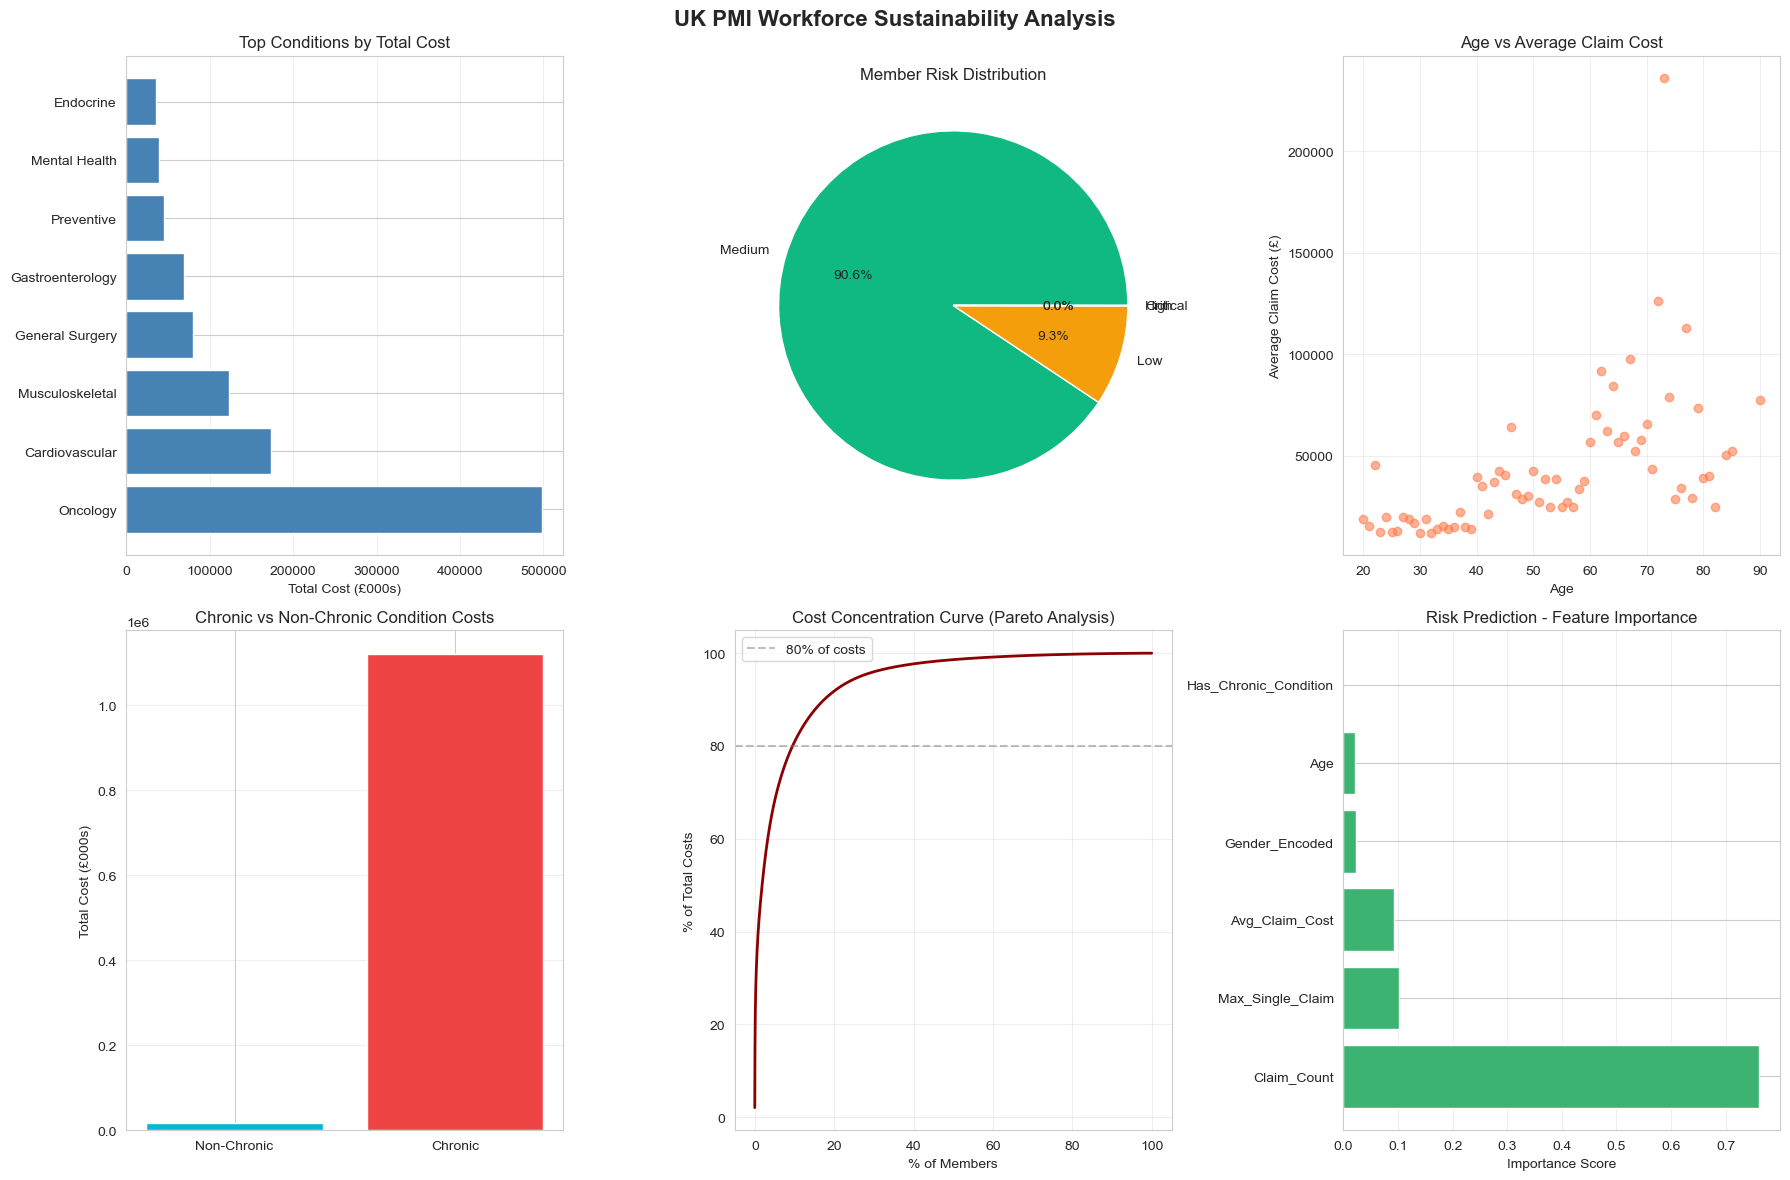

In [10]:
# ===========================
# 8. VISUALIZATIONS
# ===========================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('UK PMI Workforce Sustainability Analysis', fontsize=16, fontweight='bold')

# 1. Condition Cost Distribution
ax1 = axes[0, 0]
top_conditions = condition_analysis.head(8)
ax1.barh(top_conditions['Condition'], top_conditions['Total_Cost']/1000, color='steelblue')
ax1.set_xlabel('Total Cost (£000s)')
ax1.set_title('Top Conditions by Total Cost')
ax1.grid(axis='x', alpha=0.3)

# 2. Risk Category Distribution
ax2 = axes[0, 1]
risk_counts = member_summary['Risk_Category'].value_counts()
colors = ['#10b981', '#f59e0b', '#ef4444', '#dc2626']
ax2.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', colors=colors)
ax2.set_title('Member Risk Distribution')

# 3. Age vs Cost
ax3 = axes[0, 2]
age_analysis = member_summary.groupby('Age')['Total_Claim_Cost'].mean().reset_index()
ax3.scatter(age_analysis['Age'], age_analysis['Total_Claim_Cost'], alpha=0.6, color='coral')
ax3.set_xlabel('Age')
ax3.set_ylabel('Average Claim Cost (£)')
ax3.set_title('Age vs Average Claim Cost')
ax3.grid(alpha=0.3)

# 4. Chronic vs Non-Chronic Costs
ax4 = axes[1, 0]
chronic_comparison = member_summary.groupby('Has_Chronic_Condition')['Total_Claim_Cost'].sum()
ax4.bar(['Non-Chronic', 'Chronic'], chronic_comparison.values/1000, color=['#06b6d4', '#ef4444'])
ax4.set_ylabel('Total Cost (£000s)')
ax4.set_title('Chronic vs Non-Chronic Condition Costs')
ax4.grid(axis='y', alpha=0.3)

# 5. High Cost Member Concentration
ax5 = axes[1, 1]
member_summary_sorted = member_summary.sort_values('Total_Claim_Cost', ascending=False)
member_summary_sorted['Cumulative_Pct'] = (member_summary_sorted['Total_Claim_Cost'].cumsum() / 
                                            member_summary_sorted['Total_Claim_Cost'].sum() * 100)
member_summary_sorted['Member_Pct'] = np.arange(1, len(member_summary_sorted)+1) / len(member_summary_sorted) * 100
ax5.plot(member_summary_sorted['Member_Pct'], member_summary_sorted['Cumulative_Pct'], 
         linewidth=2, color='darkred')
ax5.axhline(80, color='gray', linestyle='--', alpha=0.5, label='80% of costs')
ax5.set_xlabel('% of Members')
ax5.set_ylabel('% of Total Costs')
ax5.set_title('Cost Concentration Curve (Pareto Analysis)')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Feature Importance
ax6 = axes[1, 2]
ax6.barh(feature_importance['Feature'], feature_importance['Importance'], color='mediumseagreen')
ax6.set_xlabel('Importance Score')
ax6.set_title('Risk Prediction - Feature Importance')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('pmi_workforce_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# ===========================
# 9. DETAILED CONDITION ANALYSIS
# ===========================

print("\n" + "="*80)
print("DETAILED CONDITION-SPECIFIC ANALYSIS")
print("="*80)

# Chronic condition breakdown
chronic_df = merged_df[merged_df['Is_Chronic'] == True]
chronic_analysis = chronic_df.groupby('Condition_Category').agg({
    'Claim Amount': ['sum', 'mean', 'count'],
    'Claimant Unique ID': 'nunique'
}).reset_index()

chronic_analysis.columns = ['Condition', 'Total_Cost', 'Avg_Cost', 'Claims', 'Members']
chronic_analysis['Cost_Per_Member'] = chronic_analysis['Total_Cost'] / chronic_analysis['Members']
chronic_analysis = chronic_analysis.sort_values('Total_Cost', ascending=False)

print("\n CHRONIC CONDITION BREAKDOWN:")
print(chronic_analysis.to_string(index=False))


DETAILED CONDITION-SPECIFIC ANALYSIS

 CHRONIC CONDITION BREAKDOWN:
               Condition   Total_Cost     Avg_Cost  Claims  Members  Cost_Per_Member
                Oncology 498716237.15 16331.005212   30538    12570     39675.118309
          Cardiovascular 173883660.90  6659.912708   26109    10608     16391.747822
 Musculoskeletal_Chronic 122845253.00  2836.024864   43316    16619      7391.855888
Gastroenterology_Chronic  69357670.15  3746.430624   18513     8844      7842.341718
   Mental_Health_Chronic  62023875.52  2206.470136   28110    12718      4876.857644
       Endocrine_Chronic  58073443.46  3726.956967   15582     7585      7656.353785
     Respiratory_Chronic  22869243.55  3630.614947    6299     3780      6050.064431


In [12]:
# ===========================
# 10. EXPORT RESULTS FOR CLIENT PRESENTATION
# ===========================

# Export key datasets
high_cost_members.to_csv('high_cost_members_report.csv', index=False)
intervention_candidates.to_csv('intervention_candidates.csv', index=False)
member_summary.to_csv('member_risk_summary.csv', index=False)
condition_analysis.to_csv('condition_cost_analysis.csv', index=False)

print("\n" + "="*80)
print("EXECUTIVE SUMMARY FOR CLIENT")
print("="*80)

print(f"""
📊 WORKFORCE SUSTAINABILITY - KEY METRICS

1. MEMBERSHIP OVERVIEW
   • Total Members Analyzed: {len(member_summary):,}
   • Members with Claims: {len(member_summary):,}
   • Total Claims: {len(merged_df):,}

2. HIGH-COST CONDITIONS
   • Members with Chronic Conditions: {member_summary['Has_Chronic_Condition'].sum():,} ({member_summary['Has_Chronic_Condition'].sum()/len(member_summary)*100:.1f}%)
   • High-Cost Members (>£20k): {len(high_cost_members):,} ({len(high_cost_members)/len(member_summary)*100:.1f}%)
   • Critical Risk Members: {len(member_summary[member_summary['Risk_Category']=='Critical']):,}

3. COST CONCENTRATION
   • Top 10% Members Account for: {member_summary.nlargest(int(len(member_summary)*0.1), 'Total_Claim_Cost')['Total_Claim_Cost'].sum()/member_summary['Total_Claim_Cost'].sum()*100:.1f}% of costs
   • Top 20% Members Account for: {member_summary.nlargest(int(len(member_summary)*0.2), 'Total_Claim_Cost')['Total_Claim_Cost'].sum()/member_summary['Total_Claim_Cost'].sum()*100:.1f}% of costs

4. INTERVENTION OPPORTUNITIES
   • Members Requiring Intervention: {len(intervention_candidates):,}
   • Potential Cost Savings (10% reduction): £{intervention_candidates['Total_Claim_Cost'].sum()*0.1:,.2f}
   • Potential Cost Savings (20% reduction): £{intervention_candidates['Total_Claim_Cost'].sum()*0.2:,.2f}

5. TOP 3 HIGH-COST CONDITIONS
""")

for idx, row in condition_analysis.head(3).iterrows():
    print(f"   {idx+1}. {row['Condition']}: £{row['Total_Cost']:,.2f} ({row['Member_Count']:,} members)")

print(f"""
6. RECOMMENDED ACTIONS
   ✓ Implement chronic disease management for {member_summary['Has_Chronic_Condition'].sum():,} members
   ✓ Deploy intensive case management for {len(intervention_candidates[intervention_candidates['Intervention_Type']=='Intensive_Case_Management']):,} critical cases
   ✓ Launch preventive outreach for {len(intervention_candidates[intervention_candidates['Intervention_Type']=='Preventive_Outreach']):,} high-risk members
   ✓ Establish utilization management for frequent claimants

7. EXPECTED OUTCOMES
   • Reduced hospitalization rates by 15-25%
   • Decreased emergency utilization by 20-30%
   • Improved member health outcomes
   • Cost savings of £{intervention_candidates['Total_Claim_Cost'].sum()*0.15:,.2f} - £{intervention_candidates['Total_Claim_Cost'].sum()*0.25:,.2f}
""")



EXECUTIVE SUMMARY FOR CLIENT

📊 WORKFORCE SUSTAINABILITY - KEY METRICS

1. MEMBERSHIP OVERVIEW
   • Total Members Analyzed: 42,000
   • Members with Claims: 42,000
   • Total Claims: 200,000

2. HIGH-COST CONDITIONS
   • Members with Chronic Conditions: 38,080 (90.7%)
   • High-Cost Members (>£20k): 7,810 (18.6%)
   • Critical Risk Members: 2

3. COST CONCENTRATION
   • Top 10% Members Account for: 80.9% of costs
   • Top 20% Members Account for: 91.8% of costs

4. INTERVENTION OPPORTUNITIES
   • Members Requiring Intervention: 38,304
   • Potential Cost Savings (10% reduction): £113,286,705.85
   • Potential Cost Savings (20% reduction): £226,573,411.70

5. TOP 3 HIGH-COST CONDITIONS

   8. Oncology: £498,716,237.15 (12,570 members)
   1. Cardiovascular: £173,883,660.90 (10,608 members)
   7. Musculoskeletal: £122,845,253.00 (16,619 members)

6. RECOMMENDED ACTIONS
   ✓ Implement chronic disease management for 38,080 members
   ✓ Deploy intensive case management for 7,643 critical ca

In [13]:
# ===========================
# 6b. PREDICTIVE MODEL USING TARGET ENCODING (NO ONE-HOT)
# ===========================

print("\n" + "="*80)
print("PREDICTIVE RISK MODEL (TARGET ENCODING FOR CONDITION & TREATMENT)")
print("="*80)

# Reuse member_summary
modeling_df_v2 = member_summary.copy()
modeling_df_v2['High_Risk'] = (modeling_df_v2['Risk_Category'].isin(['High', 'Critical'])).astype(int)

# Label-encode Gender
from sklearn.preprocessing import LabelEncoder
le_gender_v2 = LabelEncoder()
modeling_df_v2['Gender_Encoded'] = le_gender_v2.fit_transform(modeling_df_v2['Gender'].fillna('Unknown'))

# Helper to split comma-separated tokens
from collections import defaultdict

def tokens_list(val):
    return [p.strip() for p in str(val).split(',') if str(p).strip() != '']

# Build out-of-fold target encoding for each token with smoothing
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y = modeling_df_v2['High_Risk'].values
prior = float(y.mean())
min_samples = 10  # smoothing strength (m)

cond_te_mean_oof = np.zeros(len(modeling_df_v2))
cond_te_max_oof = np.zeros(len(modeling_df_v2))
cond_count_oof = np.zeros(len(modeling_df_v2))

trt_te_mean_oof = np.zeros(len(modeling_df_v2))
trt_te_max_oof = np.zeros(len(modeling_df_v2))
trt_count_oof = np.zeros(len(modeling_df_v2))

cond_series = modeling_df_v2['Condition_Categories'].fillna("")
trt_series = modeling_df_v2['Treatment_Types'].fillna("")

for train_idx, val_idx in kfold.split(modeling_df_v2, y):
    # Aggregate token stats on training fold
    def build_token_stats(series, y_values):
        sum_y = defaultdict(float)
        cnt = defaultdict(int)
        for s, target in zip(series.iloc[train_idx], y_values[train_idx]):
            toks = tokens_list(s)
            for t in toks:
                sum_y[t] += float(target)
                cnt[t] += 1
        # compute smoothed means
        te_map = {}
        for t, c in cnt.items():
            te_map[t] = (sum_y[t] + min_samples * prior) / (c + min_samples)
        return te_map

    cond_map = build_token_stats(cond_series, y)
    trt_map = build_token_stats(trt_series, y)

    # Apply to validation fold
    for i in val_idx:
        cond_tokens = tokens_list(cond_series.iloc[i])
        trt_tokens = tokens_list(trt_series.iloc[i])

        cond_vals = [cond_map.get(t, prior) for t in cond_tokens] or [prior]
        trt_vals = [trt_map.get(t, prior) for t in trt_tokens] or [prior]

        cond_te_mean_oof[i] = float(np.mean(cond_vals))
        cond_te_max_oof[i] = float(np.max(cond_vals))
        cond_count_oof[i] = float(len(cond_tokens))

        trt_te_mean_oof[i] = float(np.mean(trt_vals))
        trt_te_max_oof[i] = float(np.max(trt_vals))
        trt_count_oof[i] = float(len(trt_tokens))

# Attach encoded features
modeling_df_v2['COND_TE_MEAN'] = cond_te_mean_oof
modeling_df_v2['COND_TE_MAX'] = cond_te_max_oof
modeling_df_v2['COND_TOKEN_COUNT'] = cond_count_oof

modeling_df_v2['TRT_TE_MEAN'] = trt_te_mean_oof
modeling_df_v2['TRT_TE_MAX'] = trt_te_max_oof
modeling_df_v2['TRT_TOKEN_COUNT'] = trt_count_oof

# Base numeric features + encoded aggregates
base_features = [
    'Age', 'Claim_Count', 'Avg_Claim_Cost', 'Max_Single_Claim',
    'Has_Chronic_Condition', 'Gender_Encoded'
]
encoded_features = [
    'COND_TE_MEAN', 'COND_TE_MAX', 'COND_TOKEN_COUNT',
    'TRT_TE_MEAN', 'TRT_TE_MAX', 'TRT_TOKEN_COUNT'
]
features_v2 = base_features + encoded_features

X_v2 = modeling_df_v2[features_v2].fillna(0)
y_v2 = modeling_df_v2['High_Risk'].values

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X2_train, X2_test, y2_train, y2_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=42, stratify=y_v2)

rf_model_v2 = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=12)
rf_model_v2.fit(X2_train, y2_train)

train_acc_v2 = rf_model_v2.score(X2_train, y2_train)
test_acc_v2 = rf_model_v2.score(X2_test, y2_test)

print(f"\nModel Performance (Target Encoded):")
print(f"Training Accuracy: {train_acc_v2:.2%}")
print(f"Testing Accuracy: {test_acc_v2:.2%}")

# Feature importance
fi_v2 = pd.DataFrame({
    'Feature': features_v2,
    'Importance': rf_model_v2.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nTop 15 Features:")
of_ = fi_v2.head(15)
print(of_.to_string(index=False))

# Build final token maps on full data for inference
from collections import defaultdict

def build_full_te_map(series, y_values, prior_value, m=10):
    sum_y = defaultdict(float)
    cnt = defaultdict(int)
    for s, target in zip(series, y_values):
        for t in tokens_list(s):
            sum_y[t] += float(target)
            cnt[t] += 1
    te_map = {}
    for t, c in cnt.items():
        te_map[t] = (sum_y[t] + m * prior_value) / (c + m)
    return te_map

cond_te_map_full = build_full_te_map(cond_series, y_v2, prior, m=min_samples)
trt_te_map_full = build_full_te_map(trt_series, y_v2, prior, m=min_samples)

# Store artifacts for inference
MODEL_ARTIFACTS_V2 = {
    'model': rf_model_v2,
    'features': features_v2,
    'le_gender': le_gender_v2,
    'prior': prior,
    'm': min_samples,
    'cond_te_map': cond_te_map_full,
    'trt_te_map': trt_te_map_full
}

# Attach probabilities for inspection
modeling_df_v2['Risk_Probability_v2'] = rf_model_v2.predict_proba(X_v2)[:, 1]
print("\nArtifacts ready: MODEL_ARTIFACTS_V2 with model, features, encoders, and TE maps.")



PREDICTIVE RISK MODEL (TARGET ENCODING FOR CONDITION & TREATMENT)

Model Performance (Target Encoded):
Training Accuracy: 100.00%
Testing Accuracy: 99.98%

Top 15 Features:
              Feature  Importance
          Claim_Count    0.707815
     Max_Single_Claim    0.093230
       Avg_Claim_Cost    0.085272
          TRT_TE_MEAN    0.033740
           TRT_TE_MAX    0.023183
     COND_TOKEN_COUNT    0.015893
                  Age    0.014869
          COND_TE_MAX    0.011071
         COND_TE_MEAN    0.009715
       Gender_Encoded    0.005111
      TRT_TOKEN_COUNT    0.000057
Has_Chronic_Condition    0.000045

Artifacts ready: MODEL_ARTIFACTS_V2 with model, features, encoders, and TE maps.


In [25]:
modeling_df_v2[modeling_df_v2['High_Risk'] ==1]

,Claimant Unique ID,Total_Claim_Cost,Avg_Claim_Cost,Claim_Count,Max_Single_Claim,Total_Paid,Has_Chronic_Condition,Age,Gender,Condition_Categories,...,Risk_Category,High_Risk,Gender_Encoded,COND_TE_MEAN,COND_TE_MAX,COND_TOKEN_COUNT,TRT_TE_MEAN,TRT_TE_MAX,TRT_TOKEN_COUNT,Risk_Probability_v2
894,MEM00001109-03,7800805.66,5968.481760,1307,241680.34,7324550.19,True,20,Male,"Musculoskeletal, Oncology, Respiratory, Preven...",...,High,1,1,0.001330,0.002376,11.0,0.000622,0.000852,3.0,0.920000
3109,MEM00003847-02,23495228.49,5912.236661,3974,240124.49,21688356.52,True,46,Female,"Musculoskeletal, Oncology, Preventive, Mental ...",...,Critical,1,0,0.001336,0.002410,11.0,0.000283,0.000680,3.0,0.906667
3428,MEM00004229-02,5916222.63,7232.546002,818,229680.46,5543072.73,True,67,Male,"Cardiovascular, Oncology, Musculoskeletal, Oph...",...,High,1,1,0.001329,0.002358,11.0,0.000264,0.000538,3.0,0.000000
6713,MEM00008387-03,7580150.15,5504.829448,1377,239832.22,7063378.24,True,20,Male,"Musculoskeletal, Cardiovascular, Preventive, M...",...,High,1,1,0.001333,0.002333,11.0,0.000398,0.000678,3.0,0.883333
20047,MEM00025163-03,8185718.44,5065.419827,1616,218966.86,7629382.55,True,20,Female,"Respiratory, Musculoskeletal, General Surgery,...",...,High,1,0,0.001329,0.002358,11.0,0.000529,0.000847,3.0,0.833333
20137,MEM00025284-02,9479323.95,5961.838962,1590,243872.21,8833082.93,True,46,Male,"Musculoskeletal, Respiratory, General Surgery,...",...,High,1,1,0.001336,0.002410,11.0,0.000348,0.000680,3.0,0.920000
27392,MEM00034428-01,14167150.29,5547.043966,2554,229236.63,13087893.35,True,44,Male,"Preventive, Oncology, Endocrine, Cardiovascula...",...,Critical,1,1,0.001525,0.002690,11.0,0.000260,0.000331,3.0,0.643333
28406,MEM00035764-02,7319998.39,5086.864760,1439,224773.58,6838207.93,True,50,Male,"Endocrine, Cardiovascular, Musculoskeletal, On...",...,High,1,1,0.001333,0.002333,11.0,0.000568,0.000678,3.0,0.830000
30123,MEM00038007-01,12077548.45,5583.702473,2163,249793.56,11276128.99,True,45,Male,"Mental Health, Ophthalmology, Musculoskeletal,...",...,High,1,1,0.001330,0.002376,11.0,0.000149,0.000248,3.0,0.856667


In [23]:
# ===========================
# 6c. INFERENCE: PICK A ROW AND PREDICT (TARGET ENCODING)
# ===========================

import numpy as np

def build_feature_row_from_member(member_row, artifacts):
    """Build a single-row feature DataFrame aligned to training features (target-encoded).
    member_row: Series from modeling_df_v2
    artifacts: MODEL_ARTIFACTS_V2 dict
    """
    features = artifacts['features']
    le_gender = artifacts['le_gender']
    prior = artifacts['prior']
    cond_map = artifacts['cond_te_map']
    trt_map = artifacts['trt_te_map']

    # Start with zeros
    row_dict = {f: 0 for f in features}

    # Base numeric features
    row_dict['Age'] = member_row.get('Age', 0) or 0
    row_dict['Claim_Count'] = member_row.get('Claim_Count', 0) or 0
    row_dict['Avg_Claim_Cost'] = member_row.get('Avg_Claim_Cost', 0) or 0
    row_dict['Max_Single_Claim'] = member_row.get('Max_Single_Claim', 0) or 0
    row_dict['Has_Chronic_Condition'] = int(member_row.get('Has_Chronic_Condition', 0) or 0)
    row_dict['Gender_Encoded'] = int(le_gender.transform([str(member_row.get('Gender', 'Unknown') or 'Unknown')])[0])

    # Tokens
    def tokens_from_field(val):
        return [p.strip() for p in str(val).split(',') if str(p).strip() != '']

    cond_tokens = tokens_from_field(member_row.get('Condition_Categories', ''))
    trt_tokens = tokens_from_field(member_row.get('Treatment_Types', ''))

    # Target-encoded aggregates
    cond_vals = [cond_map.get(t, prior) for t in cond_tokens] or [prior]
    trt_vals = [trt_map.get(t, prior) for t in trt_tokens] or [prior]

    agg = {
        'COND_TE_MEAN': float(np.mean(cond_vals)),
        'COND_TE_MAX': float(np.max(cond_vals)),
        'COND_TOKEN_COUNT': float(len(cond_tokens)),
        'TRT_TE_MEAN': float(np.mean(trt_vals)),
        'TRT_TE_MAX': float(np.max(trt_vals)),
        'TRT_TOKEN_COUNT': float(len(trt_tokens)),
    }
    for k, v in agg.items():
        if k in row_dict:
            row_dict[k] = v

    # Return as single-row DataFrame in the correct column order
    return pd.DataFrame([[row_dict[f] for f in features]], columns=features)


def predict_member(row_selector, artifacts=MODEL_ARTIFACTS_V2):
    """Predict risk probability for a single member.
    row_selector can be:
      - int: positional index in modeling_df_v2
      - value of 'Claimant Unique ID'
    Returns dict with id, predicted label, and probability.
    """
    model = artifacts['model']
    features = artifacts['features']

    # Find the row
    if isinstance(row_selector, int):
        member_row = modeling_df_v2.iloc[row_selector]
    else:
        # assume it's a Claimant Unique ID value
        match = modeling_df_v2[modeling_df_v2['Claimant Unique ID'] == row_selector]
        if match.empty:
            raise ValueError("No member found for the given selector.")
        member_row = match.iloc[0]

    X_one = build_feature_row_from_member(member_row, artifacts)
    prob = float(model.predict_proba(X_one)[0, 1])
    pred = int(prob >= 0.3)

    result = {
        'Claimant Unique ID': member_row.get('Claimant Unique ID', None),
        'Predicted_High_Risk': pred,
        'Risk_Probability': prob
    }
    print("Prediction:", result)
    return result

# Examples:
# Predict by positional index (e.g., 0):
# _ = predict_member(0)

# Predict by Claimant Unique ID (replace with a real ID from modeling_df_v2):
# some_id = modeling_df_v2.iloc[0]['Claimant Unique ID']
# _ = predict_member(some_id)


In [27]:
# Predict by Claimant Unique ID (replace with a real ID from modeling_df_v2):
some_id = modeling_df_v2.iloc[20137]['Claimant Unique ID']
op = predict_member(some_id)

Prediction: {'Claimant Unique ID': 'MEM00025284-02', 'Predicted_High_Risk': 1, 'Risk_Probability': 0.86}


In [28]:
# ===========================
# 6d. PREDICTIVE MODEL USING CATBOOST TEXT FEATURES (NO ONE-HOT)
# ===========================

print("\n" + "="*80)
print("PREDICTIVE RISK MODEL (CATBOOST WITH TEXT FEATURES)")
print("="*80)

# Auto-install catboost if needed
try:
    from catboost import CatBoostClassifier, Pool
except Exception:
    import sys, subprocess
    print("Installing catboost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "catboost", "--quiet"])
    from catboost import CatBoostClassifier, Pool

cb_df = member_summary.copy()
cb_df['High_Risk'] = (cb_df['Risk_Category'].isin(['High', 'Critical'])).astype(int)

# Prepare columns
cb_df['Gender'] = cb_df['Gender'].fillna('Unknown').astype(str)
cb_df['Condition_Categories'] = cb_df['Condition_Categories'].fillna('').astype(str)
cb_df['Treatment_Types'] = cb_df['Treatment_Types'].fillna('').astype(str)

numeric_cols = ['Age', 'Claim_Count', 'Avg_Claim_Cost', 'Max_Single_Claim', 'Has_Chronic_Condition']
cat_cols = ['Gender']
text_cols = ['Condition_Categories', 'Treatment_Types']
all_cols = numeric_cols + cat_cols + text_cols

X_cb = cb_df[all_cols]
y_cb = cb_df['High_Risk']

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42, stratify=y_cb)

cat_feature_indices = [all_cols.index(c) for c in cat_cols]
text_feature_indices = [all_cols.index(c) for c in text_cols]

train_pool = Pool(train_X, label=train_y, cat_features=cat_feature_indices, text_features=text_feature_indices)
test_pool = Pool(test_X, label=test_y, cat_features=cat_feature_indices, text_features=text_feature_indices)

cb_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=False,
    task_type='CPU'
)

cb_model.fit(train_pool, eval_set=test_pool, verbose=False)

from sklearn.metrics import roc_auc_score, accuracy_score
train_pred = cb_model.predict_proba(train_pool)[:, 1]
test_pred = cb_model.predict_proba(test_pool)[:, 1]
train_acc = accuracy_score(train_y, (train_pred >= 0.5).astype(int))
test_acc = accuracy_score(test_y, (test_pred >= 0.5).astype(int))
train_auc = roc_auc_score(train_y, train_pred)
test_auc = roc_auc_score(test_y, test_pred)

print(f"\nModel Performance (CatBoost):")
print(f"Training Accuracy: {train_acc:.2%} | AUC: {train_auc:.3f}")
print(f"Testing Accuracy:  {test_acc:.2%} | AUC: {test_auc:.3f}")

MODEL_ARTIFACTS_CB = {
    'model': cb_model,
    'all_cols': all_cols,
    'cat_feature_indices': cat_feature_indices,
    'text_feature_indices': text_feature_indices
}

full_pool = Pool(X_cb, cat_features=cat_feature_indices, text_features=text_feature_indices)
cb_df['Risk_Probability_CB'] = cb_model.predict_proba(full_pool)[:, 1]
print("\nArtifacts ready: MODEL_ARTIFACTS_CB with model and feature schema.")



PREDICTIVE RISK MODEL (CATBOOST WITH TEXT FEATURES)

Model Performance (CatBoost):
Training Accuracy: 100.00% | AUC: 1.000
Testing Accuracy:  99.98% | AUC: 0.989

Artifacts ready: MODEL_ARTIFACTS_CB with model and feature schema.


In [29]:
# ===========================
# 6e. INFERENCE FOR CATBOOST MODEL
# ===========================

def predict_member_cb(row_selector, artifacts=MODEL_ARTIFACTS_CB):
    """Predict with CatBoost using raw text features.
    row_selector can be:
      - int: positional index in member_summary
      - value of 'Claimant Unique ID'
    Returns dict with id, predicted label, and probability.
    """
    model = artifacts['model']
    all_cols = artifacts['all_cols']
    cat_idx = artifacts['cat_feature_indices']
    text_idx = artifacts['text_feature_indices']

    if isinstance(row_selector, int):
        row = member_summary.iloc[row_selector]
    else:
        match = member_summary[member_summary['Claimant Unique ID'] == row_selector]
        if match.empty:
            raise ValueError('No member found for the given selector.')
        row = match.iloc[0]

    # Build single-row input preserving raw strings for text and categorical
    data = {c: None for c in all_cols}
    data['Age'] = row.get('Age', 0) or 0
    data['Claim_Count'] = row.get('Claim_Count', 0) or 0
    data['Avg_Claim_Cost'] = row.get('Avg_Claim_Cost', 0) or 0
    data['Max_Single_Claim'] = row.get('Max_Single_Claim', 0) or 0
    data['Has_Chronic_Condition'] = int(row.get('Has_Chronic_Condition', 0) or 0)
    data['Gender'] = str(row.get('Gender', 'Unknown') or 'Unknown')
    data['Condition_Categories'] = str(row.get('Condition_Categories', '') or '')
    data['Treatment_Types'] = str(row.get('Treatment_Types', '') or '')

    X_one = pd.DataFrame([data], columns=all_cols)
    pool_one = Pool(X_one, cat_features=cat_idx, text_features=text_idx)
    prob = float(model.predict_proba(pool_one)[0, 1])
    pred = int(prob >= 0.5)

    result = {
        'Claimant Unique ID': row.get('Claimant Unique ID', None),
        'Predicted_High_Risk': pred,
        'Risk_Probability': prob
    }
    print('CatBoost Prediction:', result)
    return result

# Examples:
# _ = predict_member_cb(0)
# some_id = member_summary.iloc[0]['Claimant Unique ID']
# _ = predict_member_cb(some_id)


In [ ]:
#some_id = member_summary.iloc[0]['Claimant Unique ID']
_ = predict_member_cb('MEM00025284-02')

CatBoost Prediction: {'Claimant Unique ID': 'MEM00025284-02', 'Predicted_High_Risk': 1, 'Risk_Probability': 0.997340252261627}


In [34]:
some_id = member_summary.iloc[-1]['Claimant Unique ID']
_ = predict_member_cb(some_id)

CatBoost Prediction: {'Claimant Unique ID': 'MEM00053105-05', 'Predicted_High_Risk': 0, 'Risk_Probability': 3.3177376279670225e-07}
